## Confocal MS2 data Exploration

**Author**: Ciera Martinez (modifications: Samantha Tang)

**Objective**: Reading my MS2 data from the confocal an do exploration of how to scrape nuclei outlines an MS2 spots.

**About Data**: These were taken at and around stage 14 of Drosophila embryo development. The files are in czi.


## Sumary

- Part1a: Read in .czi files
- Part1b: Visualization of image slices and Maximum Projection
- Part 2a: Movie of Z-stack
- Part 2b: Threholdin on zstack

In [43]:
import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns


# ## Colors
# from matplotlib import cm
# from colorspacious import cspace_converter
# from collections import OrderedDict

## Set where image is displayed
%matplotlib inline 
# %matplotlib notebook 
#%matplotlib qt 

## Part 1a: Reading in and preparing data 

In [44]:
## Read in example file
array = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-04.czi")

### Checking out the image data

In [45]:
# Check that 'img' is a variable of type 'ndarray' - use Python's built-in function 'type'.
print("Loaded array is of type:", type(array))

# Print the shape of the array
print("Loaded array has shape:", array.shape)

# Check the datatype of the individual numbers in the array. You can use the array attribute 'dtype' to do so.
# Make sure you understand the output!
print("Loaded values are of type:", array.dtype)


Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (1, 1, 13, 2, 21, 928, 1389, 1)
Loaded values are of type: uint16


Our data type is uint16, which is a 16 bit data type with a range 0 to 65535. Beware! When converting data types, which I migh need to do later, this can cause serious rescaling problems. 

- [Image data and what they mean](http://scikit-image.org/docs/dev/user_guide/data_types.html)


In [46]:
## Use squeeze to get rid of channels my data doesnt have.
array = array.squeeze()

## Essentially these are (time, channel, z-stack, y-axis, and x-axis)
## - [ ] why are there 3 channels? (0,1,2), when I try to see 2, it errors out.
## - [ ] and 13 time points?  I bet is how many times the laser scanned through the stack.
array.shape ## Check

(13, 2, 21, 928, 1389)

### Part 1b: Visualization of image slices and Maximum Projection

By slicing through the array, you can see certain parts of the images. For example below you can see one slice of either channel. So essentially `array[11, 0, 5, ...]` is the 11th time point, MS2 spot channel, 5th slice of the scan. 

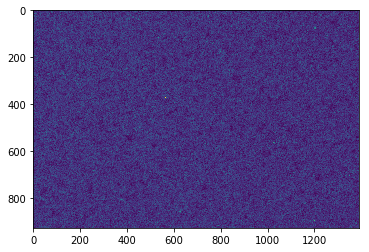

In [47]:
## Accessing and subsetting data
## 0 is MS2 channel
## 1 in chromatin channel

im = array[11, 0, 5, ...] # MS2
# im = array[11, 1, 5, ...] # Chromatin

plt.figure() #visualizing (removed just cuz too many images to scroll thr atm)
plt.imshow(im);

## -[x] why do I need both commands?
## -[] How do I slide through z-stack?

In [48]:
## Using the colon, you can get all slices scanned and make a maximum projection 
zstack = array[11, 0, :, ...] #MS2 (dots)
zstack_nuc = array[11, 1, :, ...] #nuclei
zstack.shape, zstack_nuc.shape

((21, 928, 1389), (21, 928, 1389))

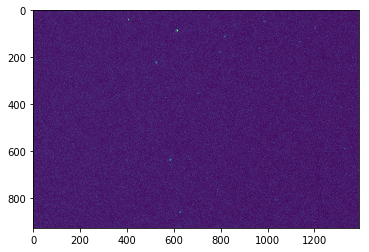

In [49]:
### View Get Maximum projection

IM_MAX= np.max(zstack, axis=0)
plt.imshow(IM_MAX) #removed visualization for now (maximum projection)
plt.show() 

## Part 2a: Movie of Z-stack

- [FuncAnimation documentation](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html)

### Questions

- What type of z-stack rendering was used? Maximum 
- Can I get both channels to be displayed?
- Why is viridis the default channel?
    - to change color: `im = ax.imshow(zstack[0, :, :], 'nipy_spectral')
    - How do I get to nice confocal color pallettes? 
    - [colormaps guide](https://matplotlib.org/tutorials/colors/colormaps.html)
 

In [16]:
#TODO: (later):
- zstack on nuclei (maximum projection) (each zstack = 1 timepoint)
- movie 
- automatic thresholding
- label

SyntaxError: invalid syntax (<ipython-input-16-e5273e73f043>, line 2)

############################################ ADDED BELOW ###########################################################

# Initial Analysis to threshold image dots (MS2)

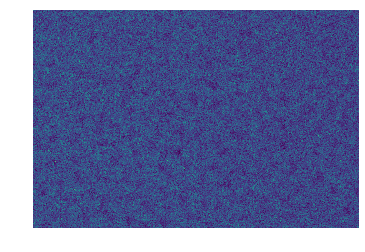

In [51]:
## go through each image in the z-stack

#fix this movie thing later (should work, or consult other notebook for fish)
fig, ax = plt.subplots()
ax.axis('off') 
#initial image?
im = ax.imshow(zstack[0, :, :])

def update(i): # setting up the first image
    # Update method - What you want your figure to look like every single time
    im.set_array(zstack[i, :, :]) 
    return [im] #returned as a iterable object as a list.
    # frames is how long, by specifing how many images
    
movie = animation.FuncAnimation(fig, update, interval=200, frames=zstack.shape[0], blit=True)
plt.show()

In [18]:
#Should have both nuc and dot below, but can't really tell? (looks kinda the same as just the nuc movie)

In [19]:
#lots of potential for information/tutorials here: 
#http://scipy-lectures.org/packages/scikit-image/index.html#id29

#TODO: 
#let's just work on one image first before we figure out how to do it for all of them 
#(and them perhaps create a movie for all these segmented images--to visualize)

#and next steps would be to gather information using these segmentations (i.e. diameter of blob, distance, etc.)


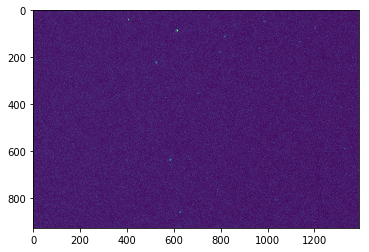

In [20]:
plt.imshow(IM_MAX) #maximum projection of all the dots for this time point

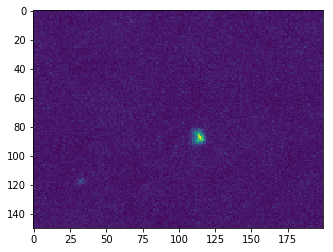

In [21]:
cropped = IM_MAX[0:150, 500:700] #cropped image from above
plt.imshow(cropped);

In [78]:
#based off of the segmentation tutorial for coins in scikit image: 
#http://scipy-lectures.org/packages/scikit-image/auto_examples/plot_boundaries.html#sphx-glr-packages-scikit-image-auto-examples-plot-boundaries-py
from skimage import data, segmentation, img_as_ubyte
from skimage import filters, feature, morphology
from ipywidgets import interact 


#otsu's method threshold: https://en.wikipedia.org/wiki/Otsu%27s_method
#simply said: the algorithm is suppose to separate foreground with background (separate into two classes, auto)

@interact(threshold = (4000, 20000))
#defaulted to the otsu threshold (does a pretty good job actually on maximum projection 
#(didn't do well for the individual images, but max is ok))
def change_threshold(threshold=16876): 
    mask = cropped > threshold #filters.threshold_otsu(cropped) #16876 #True false array to mask image
    clean_border = segmentation.clear_border(mask).astype(np.int)
    edges = segmentation.mark_boundaries(cropped, clean_border)

    plt.figure(figsize=(14, 10))
    plt.subplot(121)
    plt.imshow(clean_border, cmap="gray")
    plt.subplot(122)
    plt.imshow(edges)

interactive(children=(IntSlider(value=16876, description='threshold', max=20000, min=4000), Output()), _dom_cl…

In [59]:
filters.threshold_otsu(cropped)

16876

You can see that (from the widget above and the image histogram below), how the thresholds affect which pixels are captured in the image. That is, if we take a look at the histogram, we can see that the pixels are distributed over a range of 4000 to about 12000, with majority of the pixels centered about 7000. Correspondingly, you can play with the widget and realize that at a 4000 threshold, there are hardly any pixels shown (the yellow spots), but as you increase to a threshold of 7000, you get more and more pixels showing up in the masked image. This mirrors (supports) the image histogram which shows majority of pixels surrounded in the 7000 bin.

But since our goal is to isolate the spots (which are "whiter/brighter" than its background, we would expect these pixels (corresponding to the spots) to have higher pixel values and also make up less of the image (signifiying that these values are closer to the right of the histogram). Note that the image histogram shown below shows the pixel values for an image encoded in 16 bits (not the standard 8 bits that ranges from 0-255). Thus the pixel bins are much larger/have larger spread. This is mainly/probably encoded as such cuz we can include more imformation/details for these images (dots are really small).

And you'll realize that if I do convert the image into 8 bits, there is quite a bit of precision lost (as can be seen by the rather rigid curve of the 8 bit cropped image histogram below). 

In [60]:
#0 pixel is black, 255 is white

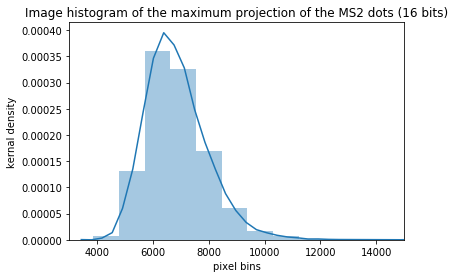

In [61]:
sns.distplot(cropped.ravel(),  kde=True); #.ravel flattens 3d array into 1d to plot histogram
plt.xlim([3000, 15000]);
plt.title("Image histogram of the maximum projection of the MS2 dots (16 bits)");
plt.ylabel("kernal density")
plt.xlabel("pixel bins");
# plt.axvline(filters.threshold_otsu(cropped), color="red");

In [62]:
cropped_8_bit = img_as_ubyte(cropped)
cropped_8_bit #may have precision loss from converting from 16 to 8 bit

/Users/samanthatang/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


array([[28, 29, 22, ..., 27, 27, 26],
       [32, 31, 25, ..., 26, 24, 23],
       [37, 31, 25, ..., 33, 27, 29],
       ...,
       [28, 39, 25, ..., 23, 31, 28],
       [29, 25, 33, ..., 24, 24, 19],
       [28, 33, 25, ..., 27, 25, 29]], dtype=uint8)

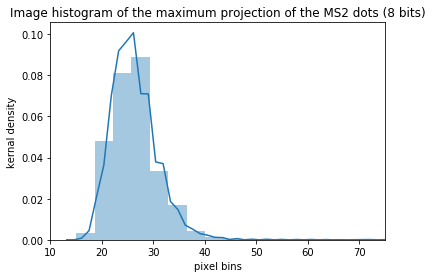

In [63]:
sns.distplot(cropped_8_bit.ravel(),  kde=True); #.ravel flattens 3d array into 1d to plot histogram
plt.xlim([10, 75]);
plt.title("Image histogram of the maximum projection of the MS2 dots (8 bits)");
plt.ylabel("kernal density")
plt.xlabel("pixel bins");

# THRESHOLD MAX PROJECTION OF MS2

Now, let's try this on the uncropped image and see if we can still locate the dots.

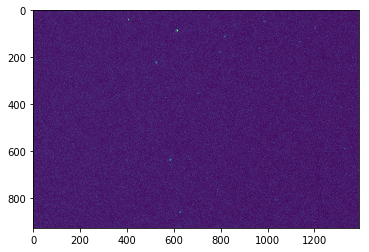

In [64]:
plt.imshow(IM_MAX) #MAX PROJECTION

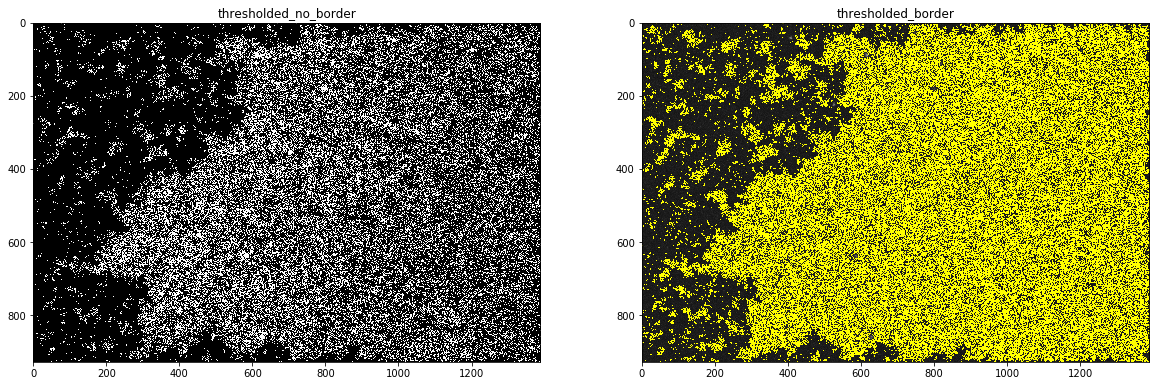

In [65]:
mask = IM_MAX > filters.threshold_otsu(IM_MAX) #True false array to mask image
clean_border = segmentation.clear_border(mask).astype(np.int)
edges = segmentation.mark_boundaries(IM_MAX, clean_border)

plt.figure(figsize=(20, 14))
plt.subplot(121)
plt.imshow(clean_border, cmap="gray")
plt.title("thresholded_no_border")
plt.subplot(122)
plt.imshow(edges)
plt.title("thresholded_border");

OMG, why does this happen? Let's take a look at this in parts, because this obviously isn't doing what we want.

So we know that the general/top-view understanding of how otsu works is that the algorithm generates a threshold value by minimizing intra-class variance and maximizes inter-class variance. (i.e. the goal is the provide a threshold to separate the "background" (in our case, the blackness/void) from the "foreground" (in our case, the dots). Therefore, let's take a look at the image histogram (of the entire MAXIMUM PROJECTION) and see where the otsu algorithm calculated the threshold value to be.

Threshold value:  7019


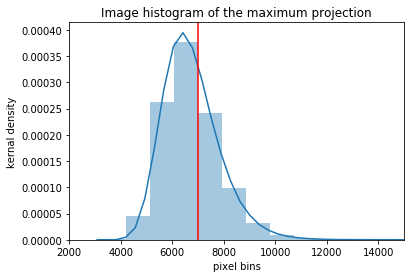

In [66]:
thresh = filters.threshold_otsu(IM_MAX)

sns.distplot(IM_MAX.ravel(),  kde=True); #.ravel flattens 3d array into 1d to plot histogram
plt.xlim([2000, 15000]);
plt.title("Image histogram of the maximum projection");
plt.ylabel("kernal density")
plt.xlabel("pixel bins");
plt.axvline(thresh, color="red");

print("Threshold value: ", thresh)

But if we compare this calculated threshold value with the otsu threshold found for the cropped image, we see that there is a drastic difference in where this threshold line lies on the graph, which gives us pretty good idea as to why we saw a "success" in automatically isolating the MS2 dot in the cropped image and why we saw a "failure" in using the same method to isolate the dots for the entire IM_MAX projection.

Notice, below, that the calculated ostu threshold value is way farther away to the right of the histogram, therefore capturing less pixels (and isolating the dot we want). On the other hand, (above), we see that the image histogram for the IM_MAX calculated a threshold that was nearly right in the middle/peak of the histogram (albiet a little to the right). This threshold will result in us capturing all the remaining pixels to the right of this red line, threfore, resulting in the large blob of yellow we saw before.

So why is this the case? That is, why did it work for the cropped image and not for the entire IM_MAX image?

Otsu thresholding works best under the assumption that there is a bimodel (2) distribution of the pixel images. But in our case, there is clearly not 2 distinct pixel groups in our IM_MAX (as opposed to the cropped image, which apparently, has a small "bimodel" distribution if we look closely, see below histogram 2). Moreover, when our "foreground" or "object area" that we want to isolate, is small in comparison to the background, and this will affect the the segmentation/calculated threshold value.


Though the otsu algorithm might work great for the nuclus, not so great for the MS2, most likely because of the size.

References: 
1. [wiki](https://en.wikipedia.org/wiki/Otsu%27s_method) # see limitations (also a really good gif here that I might include in notebook for visual reference later, remember to cite tho)
2. [skiimage](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html)

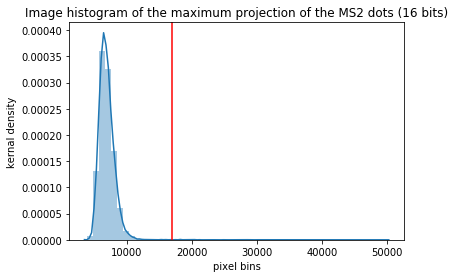

In [67]:
sns.distplot(cropped.ravel(),  kde=True); #.ravel flattens 3d array into 1d to plot histogram
# plt.xlim([3000, 15000]);
plt.title("Image histogram of the maximum projection of the MS2 dots (16 bits)");
plt.ylabel("kernal density")
plt.xlabel("pixel bins");
plt.axvline(filters.threshold_otsu(cropped), color="red");

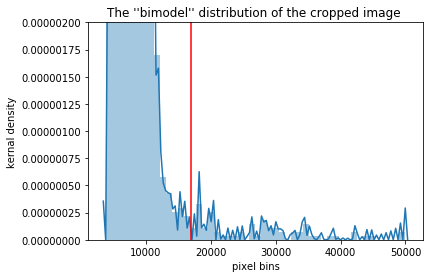

In [68]:
sns.distplot(cropped.ravel(),  kde=True); #.ravel flattens 3d array into 1d to plot histogram
plt.ylim([0, 0.000002]);
plt.title("The ''bimodel'' distribution of the cropped image ");
plt.ylabel("kernal density")
plt.xlabel("pixel bins");
plt.axvline(filters.threshold_otsu(cropped), color="red");

Though, after playing around with the thresholding (ostu), I realized that simply using the otsu threshold value from the cropped image is enough to isolate the dots in the IM_MAX. (or at least it does a pretty good job (but still has noise), at least much better than (re)calculating a threshold value from the entire IM_MAX since the pixel distributions are suited for otsu thresholding). See below for the dots isolated using the threshold value found/calculated from one dot cropped from the entire IM_MAX.

But since our goal is to find a way to automate this process of finding a threshold value, we should keep experimenting/looking.

In [69]:
#enlarged below for comparison

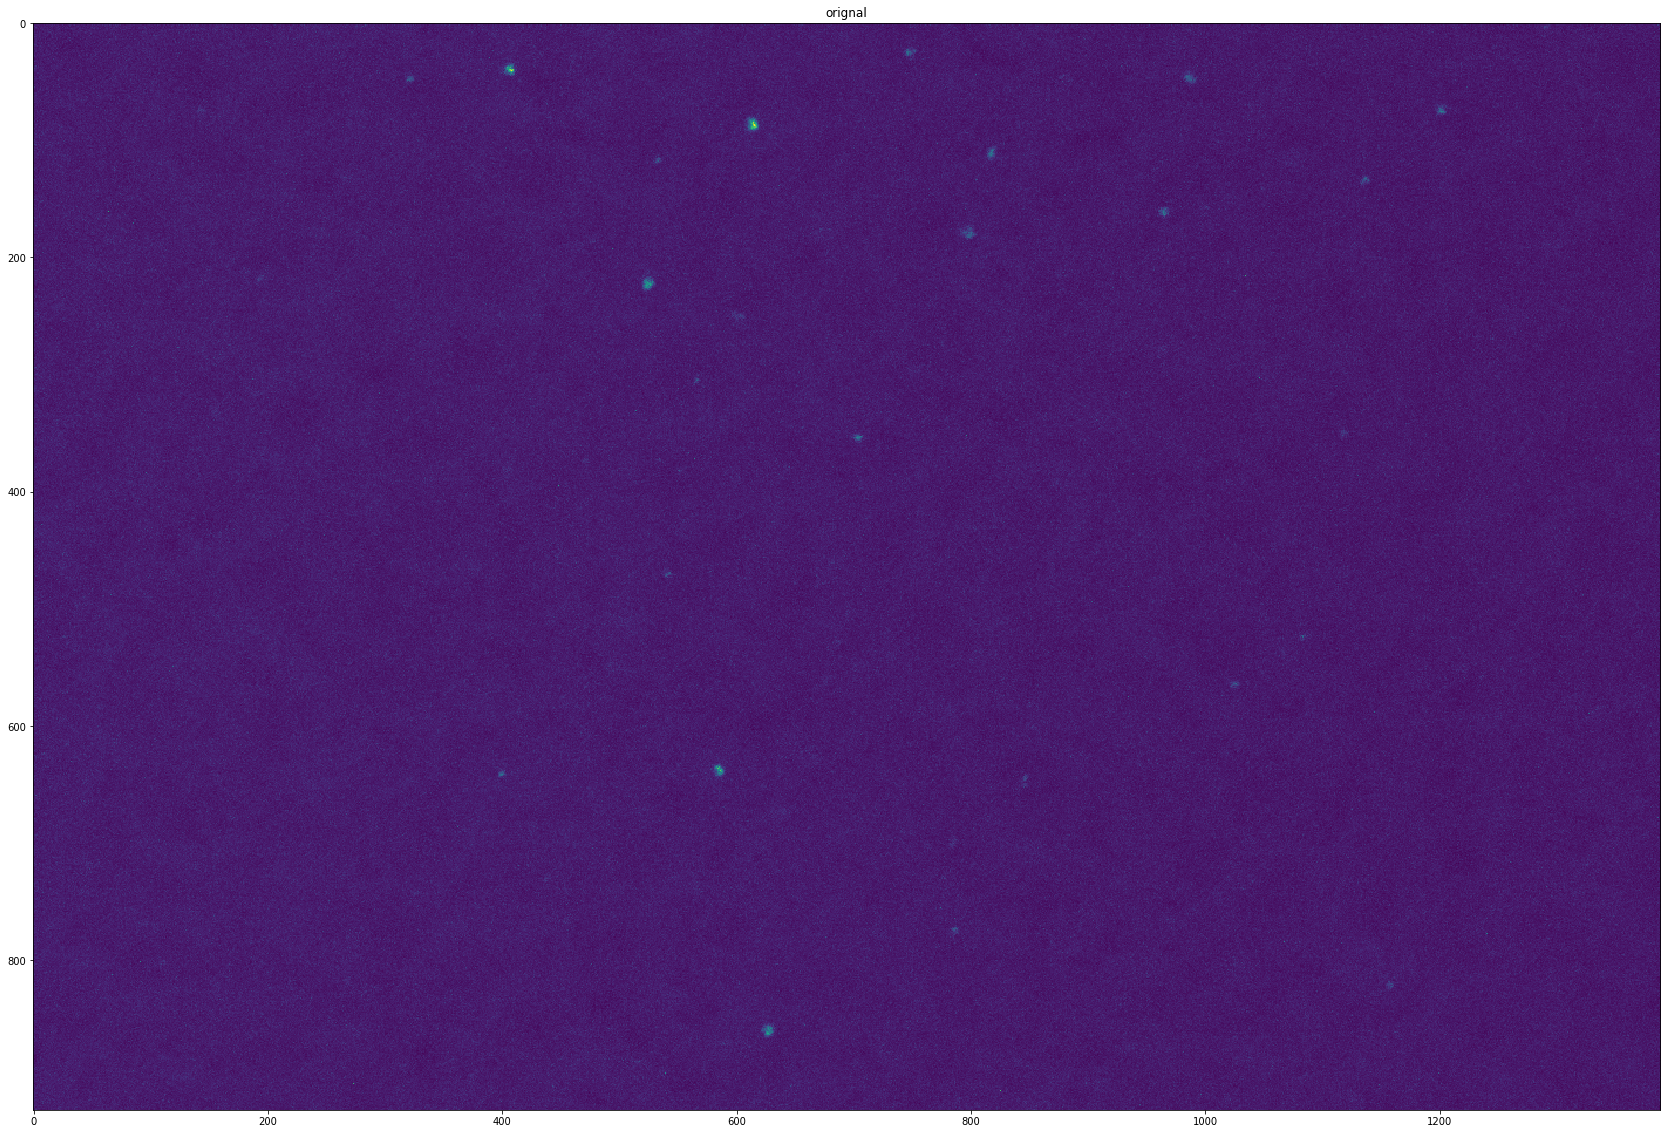

In [70]:
plt.figure(figsize=(40, 20))
plt.imshow(IM_MAX)
plt.title("orignal");

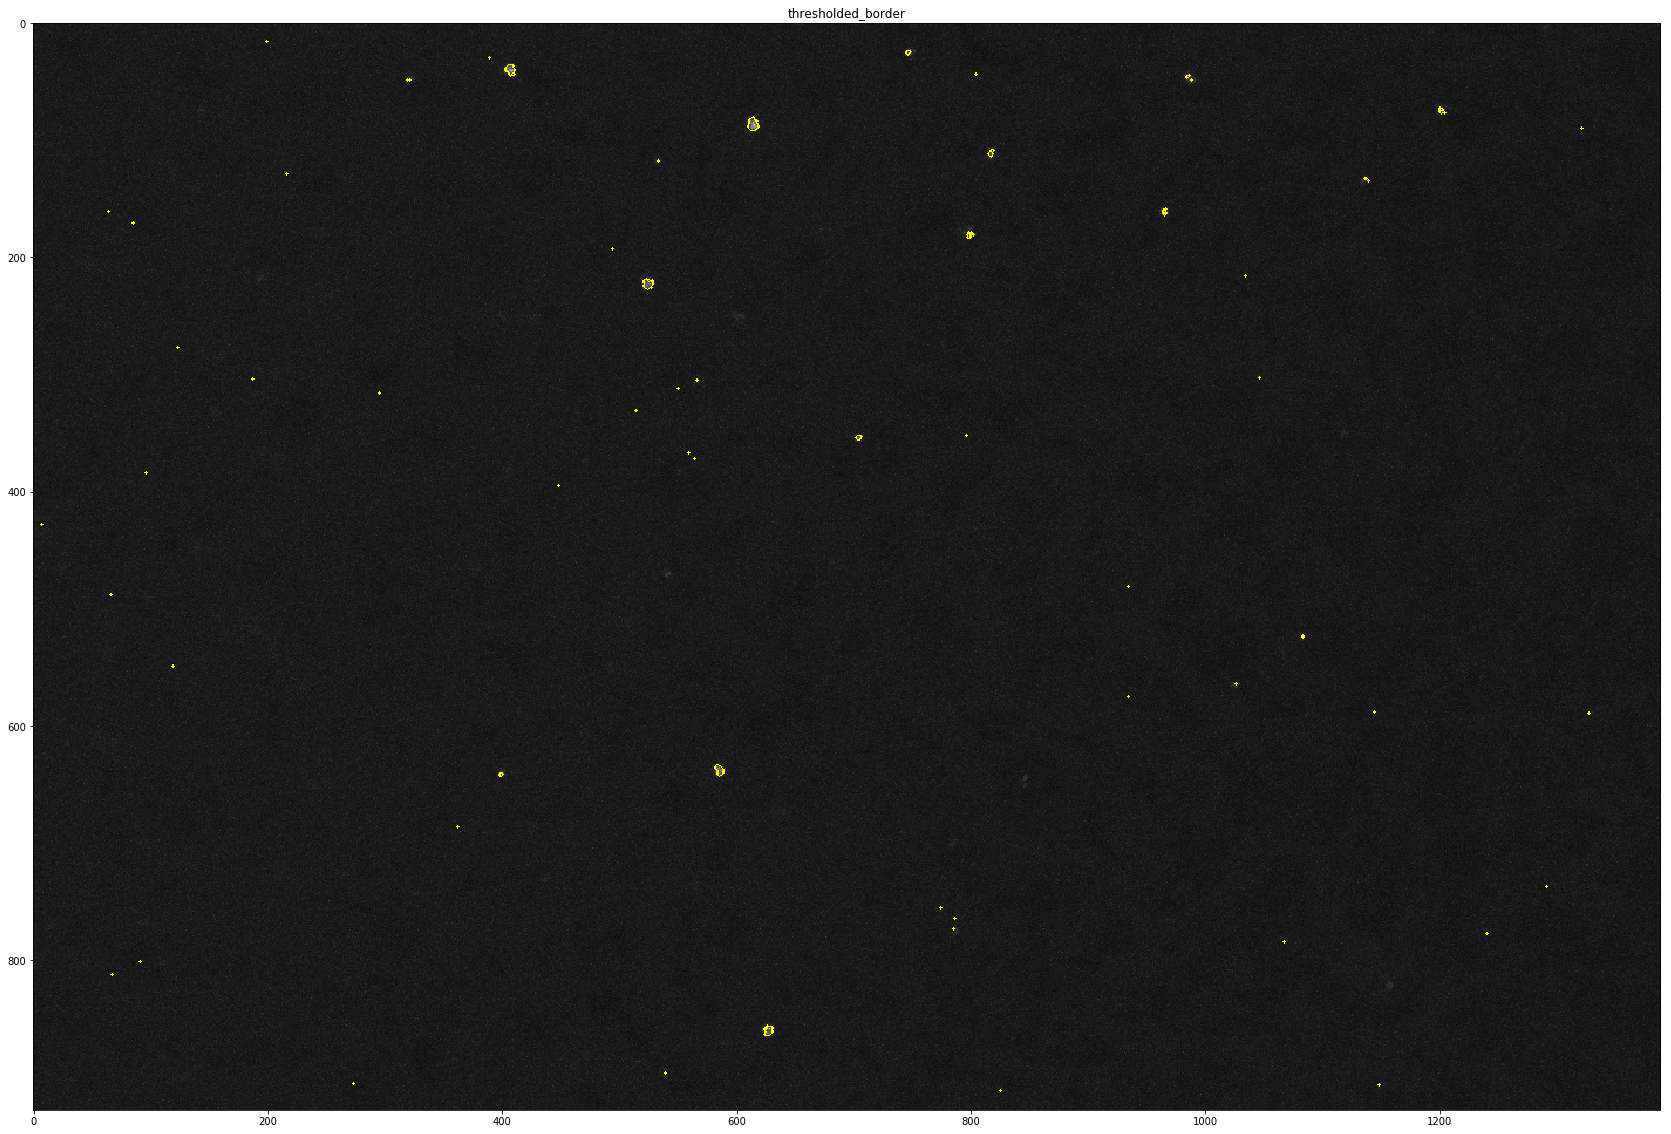

In [71]:
mask = IM_MAX > filters.threshold_otsu(cropped)
clean_border = segmentation.clear_border(mask).astype(np.int)
edges = segmentation.mark_boundaries(IM_MAX, clean_border)

plt.figure(figsize=(40, 20))
plt.imshow(edges)
plt.title("thresholded_border");

In [1]:
#experimenting with different threshold algorithms
# will try different ways, maybe find centers? consult cieras notebook, also look at matlab documentation!

## Setting a color threshold 

This is so I can take the noise away and see onl the MS2 dots.

- [Tutorial](https://matplotlib.org/users/image_tutorial.html)
- [Colors](https://matplotlib.org/tutorials/colors/colormaps.html)


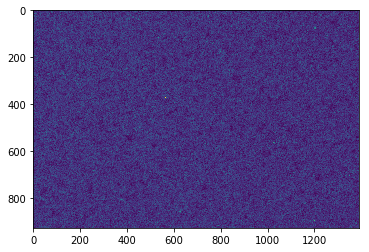

In [87]:
lum_img = array[11, 0, 5, ...]

plt.figure() # Set the stage
# This is array slicing.  You can read more in the `Numpy tutorial
# <https://docs.scipy.org/doc/numpy/user/quickstart.html>`_.

# To change color
#plt.imshow(lum_img, cmap='Greens') 

plt.imshow(lum_img) # makes the graph
plt.show() #displays the graph
# plt.colorbar() #deal with this later

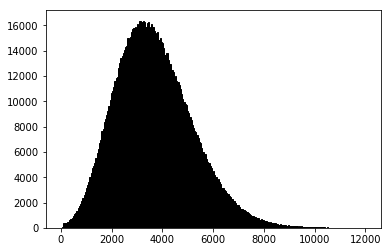

In [58]:
lum_img = array[11, 0, 5, ...]

plt.figure()
plt.hist(lum_img.ravel(), bins=256, range=(0.0, 12000), fc='k', ec='k');

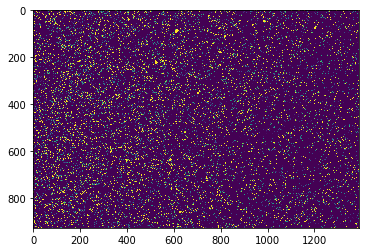

In [57]:
## Zoom in to tail of histogram
plt.figure()
imgplot = plt.imshow(lum_img, clim=(7900, 9000));

## This is good, but likely needs to be done on the maximum projection

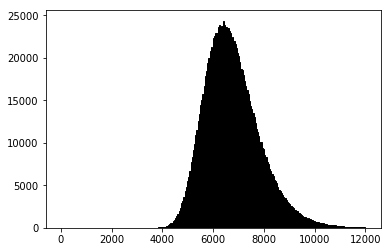

In [55]:
## access one slice of the frame
zstack = array[11, 0, :, ...]
zstack.shape
zstack
IM_MAX= np.max(zstack, axis=0)
lum_img = IM_MAX

## The threshold graph is done on the upper limit of this graph
plt.figure()
plt.hist(lum_img.ravel(), bins=256, range=(0.0, 12000), fc='k', ec='k');

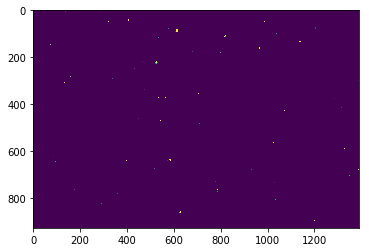

In [54]:
## Zoom in to tail of histogram
plt.figure()
imgplot = plt.imshow(lum_img, clim=(12200, 14000))

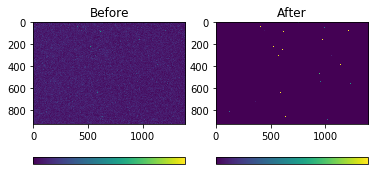

In [53]:
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(lum_img)
a.set_title('Before')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(lum_img)
imgplot.set_clim(12200, 14000)
a.set_title('After')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal');

## Next Steps

The thresholding appears to be working pretty well to identify the MS2 spots, but there is def improvement to occur.

- [ ] Try out blob detecion

In [ ]:
## Resources

- [Scipy](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- [Scikit image](https://scikit-image.org/)
